There are  88  clusters found.
ADMM with 3516 iterations
There are  21  clusters found.
ADMM with 1548 iterations
There are  5  clusters found.
ADMM with 1569 iterations
There are  47  clusters found.
There are  44  clusters found.
ADMM with 90 iterations
There are  1  clusters found.
ADMM with 6117 iterations
There are  29  clusters found.
ADMM with 4236 iterations
There are  5  clusters found.
ADMM with 4185 iterations
There are  2  clusters found.
ADMM with 4277 iterations
There are  89  clusters found.
ADMM with 5235 iterations
There are  39  clusters found.
ADMM with 4179 iterations
There are  14  clusters found.


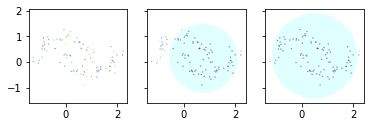

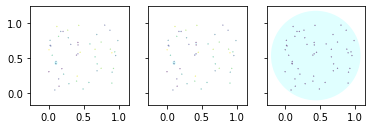

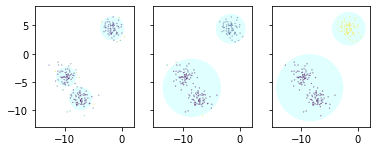

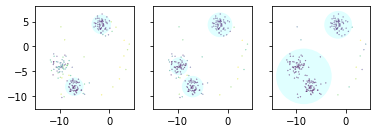

In [5]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import pandas as pd
import sys
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_diabetes

thres1 = 1e-6  # threshold to consider propotypes as "the same" or not the same due to numerical instability

tolerance = 1e-10  # tolerance of ADMM when to stop


def ccColumnNodeEdgeIncidentMatrix(n):
    # 1 -1 0
    # 1 0 -1
    # 0 1 -1
    A = np.zeros((0, n))
    for i in range(n - 1):
        # from the first block
        zp = np.zeros((n - i - 1, i))  # zero padding block
        oc = np.ones((n - i - 1, 1))  # column of 1
        t = np.concatenate((zp, oc), axis=1)
        t2 = np.concatenate((t, -1 * np.identity(n - i - 1)), axis=1)  # concat -I(n-i-1)
        A = np.concatenate((A, t2))
    return A


def ccADMMOld(U, lamda):
    # performing convex clustering using ADMM algorithm
    n, d = U.shape
    # initializating X, v, nu, Y, L
    X = np.copy(U)
    nu = 1
    Y = np.zeros((n, d))
    A = ccColumnNodeEdgeIncidentMatrix(n)
    aA = np.absolute(A)
    m, _ = A.shape
    v = np.zeros((m, d))  # new variables of fusion penalty
    L = np.zeros((m, d))  # lagrange multiplier
    lastX = np.copy(X)  # last solution to check for convergence

    for k in range(10000):
        # Update X
        for i in range(n):
            Y[i] = U[i] + np.dot(A[:, i], L + nu * v)
        X = (Y + n * nu * np.mean(U)) / (1 + n * nu)

        for i in range(m):
            delta = lamda / nu
            v[i] = proxADMM(A[i].dot(X) - (1 / nu) * L[i], delta)
            L[i] += nu * (v[i] - A[i].dot(X))

        # check stopping condition
        if np.linalg.norm(lastX - X) < tolerance:
            print('ADMM with ' + str(k) + ' iterations')
            break
        else:
            lastX = np.copy(X)

    return X


def ccADMM(U, lamda):
    # performing convex clustering using ADMM algorithm
    n, d = U.shape
    # initializating X, v, nu, Y, L
    X = np.copy(U)
    nu = 1
    Y = np.zeros((n, d))
    A = ccColumnNodeEdgeIncidentMatrix(n)
    aA = np.absolute(A)
    m, _ = A.shape
    v = np.zeros((m, d))  # new variables of fusion penalty
    L = np.zeros((m, d))  # lagrange multiplier
    lastX = np.copy(X)  # last solution to check for convergence

    for k in range(10000):
        # Update X

        Y = U + np.dot(A.transpose((1, 0)), L + nu * v)
        X = (Y + n * nu * np.mean(U)) / (1 + n * nu)

        delta = lamda / nu

        # For proxADMM
        #    A[i].dot(X) - (1 / nu) * L[i]
        AX = np.dot(A, X)
        LD = L / nu
        AXSLD = AX - LD

        # Norm
        LnormAXSLD = np.linalg.norm(AXSLD, axis=1, keepdims=True)
        iLnormAXSLD = delta / LnormAXSLD
        # max(0, 1 - delta / l) * v
        vv = (1 - iLnormAXSLD)
        vv[vv <= 0] = 0
        vv = vv * AXSLD
        v = vv
        #L += np.expand_dims(nu, axis=-1) * (vv - AX)
        L += nu * (vv - AX)
        # check stopping condition
        if np.linalg.norm(lastX - X) < tolerance:
            print('ADMM with ' + str(k) + ' iterations')
            break
        else:
            lastX = np.copy(X)

    return X


def proxADMM(v, delta):
    # print("ADMM", v.shape)
    l = np.linalg.norm(v)
    return max(0, 1 - delta / l) * v


def collectCluster(U, X, k):
    # given cluster propotypes, group samples into clusters
    n, d = U.shape
    cind = np.zeros((n, k))
    propo = np.zeros((k, d))
    # cluster 1
    cind[0, 0] = 1
    propo[0] = X[0]
    noC = 1

    for i in range(1, n):
        nfound = 1
        for j in range(noC):
            if np.linalg.norm(X[i] - propo[j]) < thres1:
                # found old cluster
                cind[i, j] = 1
                nfound = 0
                break  # break j loop
        if nfound:
            # new cluster
            cind[i, noC] = 1
            propo[noC] = X[i]
            noC = noC + 1
    indices = cind[:, 0:noC]
    return indices


def ccVizclust(U, indices, lamda, ax1):
    # visualize clustering solotions
    _, noC = indices.shape
    csize = sum(indices)
    print("There are ", noC, " clusters found.")
    # print(indices)
    # print(U)
    ccenter = np.dot(np.dot(np.diag(1 / csize), indices.transpose()), U)
    # print(ccenter)

    ax1.set_aspect('equal')
    for i in range(noC):
        circ = plt.Circle(ccenter[i], (csize[i] - 1) * lamda, zorder=1)
        # circ.set_edgecolor('red')
        circ.set_facecolor('lightcyan')
        ax1.add_patch(circ)
        # plt.gcf().gca().add_patch(circ)


def blobdata():
    # generage synthetic data
    n = 4
    np.random.seed(1)
    U1 = np.random.rand(n, 2)
    U2 = np.random.rand(n + 2, 2) + [2.5, 1]
    U3 = np.random.rand(n + 4, 2) + [1.7, 3]
    U12 = np.concatenate((U1, U2), axis=0)
    U = np.concatenate((U12, U3), axis=0)
    return U


def Gausdata():
    n = 5
    np.random.seed(1)
    dist = 4
    U1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 0.5]], 10 * n)
    U2 = np.random.multivariate_normal([dist, 0], [[0.04, 0], [0, 0.04]], 1 * n)
    # U3 = np.random.multivariate_normal([0,dist], [[1, 0], [0, 1]], 1*n)
    U12 = np.concatenate((U1, U2), axis=0)

    # U = np.concatenate((U12,U3), axis=0)
    return U12


randata = lambda: np.random.rand(20, 2)


def syndata():
    U = np.array([[0, 0], [0, -1], [0, 3], [0, 4], [1, 4], [5, 3], [5, 4], [4, 3], [4, 4]])
    return U


def suppDemo():
    print('Old supplementary demo')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
    axs = (ax1, ax2, ax3)
    np.random.seed(0)
    # U = np.random.uniform(size=(50,2))
    # lambdas = [0.01291,0.012912,0.012912]
    U = np.random.uniform(size=(20, 2))
    lambdas = [0.031, 0.03, 0.0287]

    (n, d) = U.shape
    for i in range(3):
        lamda = lambdas[i]
        X = ccADMM(U, lamda)
        # collect clusters
        indices = collectCluster(U, X, n)
        axs[i].scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=5)
        # draw colors of points #######################################################################
        _, noC = indices.shape
        aa = [*range(1, noC + 1, 1)]
        pcolor = np.dot(indices, aa)
        axs[i].scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
        axs[i].scatter(U[:, 0], U[:, 1], color='black', zorder=3, s=5)
        axs[i].set_aspect('equal')
        axs[i].set_title(r'$\lambda$=' + str(lambdas[i]))
        ccVizclust(U, indices, lamda, axs[i])
    fig.savefig("suppDemo.pdf", bbox_inches='tight')


def moonDemo(lamda, ax1, ax2, ax3):  # lamda = 0.0172
    #    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex='all', sharey = 'all')
    (U, y) = make_moons(n_samples=100, noise=0.15, random_state=1)
    (n, d) = U.shape

    X = ccADMM(U, lamda)

    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.1)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
    ax1.set_aspect('equal')
    ax1.set_title('Convex clustering')
    ccVizclust(U, indices, lamda, ax1)

    # k-means clustering
    km = KMeans(n_clusters=2)
    km.fit(U)
    kmy = km.predict(U)
    ax2.set_aspect('equal')
    ax2.scatter(U[:, 0], U[:, 1], c=kmy, s=0.1)
    ax2.set_title('K-means')

    ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
    acy = ac.fit_predict(U)
    ax3.set_aspect('equal')
    ax3.scatter(U[:, 0], U[:, 1], c=acy, s=0.1)
    ax3.set_title('Agglomerative')

    #    plt.show()
    #    fig.savefig("twomoons.pdf", bbox_inches='tight')

    print('Done.')


def uniformDemo(lamda, ax1, ax2, ax3):  # lamda = 0.0172
    np.random.seed(1)
    U = np.random.uniform(size=(50, 2))
    (n, d) = U.shape

    X = ccADMM(U, lamda)

    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.1)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
    ax1.set_aspect('equal')
    ccVizclust(U, indices, lamda, ax1)

    # k-means clustering
    km = KMeans(n_clusters=2)
    km.fit(U)
    kmy = km.predict(U)
    ax2.set_aspect('equal')
    ax2.scatter(U[:, 0], U[:, 1], c=kmy, s=0.1)

    ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
    acy = ac.fit_predict(U)
    ax3.set_aspect('equal')
    ax3.scatter(U[:, 0], U[:, 1], c=acy, s=0.1)

    #    plt.show()
    #    fig.savefig("twomoons.pdf", bbox_inches='tight')

    print('Done.')


def noisyblobsDemo(lamda, ax1, ax2, ax3):
    #    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex='all', sharey = 'all')

    # ax1.plot(x, y)
    # ax2.plot(x, -y)

    # U = blobdata() #n=4, lamda = 0.145
    # U = syndata()  #   lamda = 0.5
    # U = randata() #0.033
    # U = Gausdata()  # 0.0695

    # (U,y) = make_moons(n_samples=20,noise=0.1,random_state=1) #lamda = 0.085 2 clusters
    # next 3 lines: noisy 3 blobs lambda = 0.15
    # (U1,y) = make_blobs(n_samples=50,n_features=2,centers=3,random_state=1)
    # U2 = np.random.uniform(low=-10, high=10, size=(15,2))
    # U = np.concatenate((U1,U2))

    # 200 nodes demo
    (U1, y) = make_blobs(n_samples=180, n_features=2, centers=3, random_state=1)
    # adding noises
    U2 = np.random.uniform(low=-10, high=5, size=(20, 2))
    U = np.concatenate((U1, U2))
    # lamda = 0.042

    # 100 nodes demo
    # (U,y) = make_blobs(n_samples=100,n_features=2,centers=3,random_state=1)
    # lamda = 0.0425

    (n, d) = U.shape

    X = ccADMM(U, lamda)

    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.1)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
    ax1.set_aspect('equal')
    # ax1.set_title('Convex clustering')
    ccVizclust(U, indices, lamda, ax1)

    # k-means clustering
    km = KMeans(n_clusters=3)
    km.fit(U)
    kmy = km.predict(U)
    ax2.set_aspect('equal')
    ax2.scatter(U[:, 0], U[:, 1], c=kmy, s=0.1)
    # ax2.set_title('K-means')

    ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
    acy = ac.fit_predict(U)
    ax3.set_aspect('equal')
    ax3.scatter(U[:, 0], U[:, 1], c=acy, s=0.1)
    # ax3.set_title('Agglomerative')

    #    plt.show()
    #    fig.savefig("noisyblobs.pdf", bbox_inches='tight')

    print('Done.')


def threeblobsDemo(lamda, ax1, ax2, ax3):
    #    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex='all', sharey = 'all')

    # ax1.plot(x, y)
    # ax2.plot(x, -y)

    # U = blobdata() #n=4, lamda = 0.145
    # U = syndata()  #   lamda = 0.5
    # U = randata() #0.033
    # U = Gausdata()  # 0.0695

    # (U,y) = make_moons(n_samples=20,noise=0.1,random_state=1) #lamda = 0.085 2 clusters
    # next 3 lines: noisy 3 blobs lambda = 0.15
    # (U1,y) = make_blobs(n_samples=50,n_features=2,centers=3,random_state=1)
    # U2 = np.random.uniform(low=-10, high=10, size=(15,2))
    # U = np.concatenate((U1,U2))

    # 200 nodes demo
    (U, y) = make_blobs(n_samples=200, n_features=2, centers=3, random_state=1)
    # adding noises
    # U2 = np.random.uniform(low=-10, high=5, size=(20,2))
    # U = np.concatenate((U1,U2))
    # lamda = 0.042

    # 100 nodes demo
    # (U,y) = make_blobs(n_samples=100,n_features=2,centers=3,random_state=1)
    # lamda = 0.0425

    (n, d) = U.shape

    X = ccADMM(U, lamda)

    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.1)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
    ax1.set_aspect('equal')
    # ax1.set_title('Convex clustering')
    ccVizclust(U, indices, lamda, ax1)

    # k-means clustering
    km = KMeans(n_clusters=3)
    km.fit(U)
    kmy = km.predict(U)
    ax2.set_aspect('equal')
    ax2.scatter(U[:, 0], U[:, 1], c=kmy, s=0.1)
    # ax2.set_title('K-means')

    ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
    acy = ac.fit_predict(U)
    ax3.set_aspect('equal')
    ax3.scatter(U[:, 0], U[:, 1], c=acy, s=0.1)
    # ax3.set_title('Agglomerative')

    #    plt.show()
    #    fig.savefig("threeblobs.pdf", bbox_inches='tight')

    print('Done.')


def runTestDemo():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    (U, y) = make_moons(n_samples=100, noise=0.15, random_state=1)  # lamda = 0.085 2 clusters
    (n, d) = U.shape
    lamda = 0.0173

    X = ccADMM(U, lamda)

    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.1)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.1)
    ax1.set_aspect('equal')
    ax1.set_title('Convex clustering')
    ccVizclust(U, indices, lamda, ax1)

    ax2.scatter(X[:, 0], X[:, 1], c=pcolor, marker="+", s=0.1)
    ax2.set_aspect('equal')
    ax2.set_title('solution')

    plt.show()
    fig.savefig("test.pdf", bbox_inches='tight')


def mainDemo():
    # How difference the solutions of convex clustering are compared to that of k-means and agglomerative clusterings
    # Figure 2 in the paper
    
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    # moon demo
    lamda = 0.0172
    moonDemo(lamda, axs[0], axs[1], axs[2])
    plt.show()
    fig.savefig("main1.pdf" % sf, bbox_inches='tight')

    # uniform
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.01307
    uniformDemo(lamda, axs[0], axs[1], axs[2])
    plt.show()
    fig.savefig("main2.pdf" % sf, bbox_inches='tight')

    # threeblobdemo
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.042
    threeblobsDemo(lamda, axs[0], axs[1], axs[2])
    plt.show()
    fig.savefig("main3.pdf" % sf, bbox_inches='tight')

    # noisyblobdemo
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.042
    noisyblobsDemo(lamda, axs[0], axs[1], axs[2])
    plt.show()
    fig.savefig("main4.pdf" % sf, bbox_inches='tight')


def unidm():
    fig, axs = plt.subplots(1, 3, sharey='all')
    lamda = 0.01307
    uniformDemo(lamda, axs[0], axs[1], axs[2])
    plt.show()
    fig.savefig("uniform.pdf", bbox_inches='tight')


def cconly(U, lamda, ax1):
    # cluster data given lambda, vizualize in ax1
    (n, d) = U.shape
    X = ccADMM(U, lamda)
    # collect clusters
    indices = collectCluster(U, X, n)
    ax1.scatter(X[:, 0], X[:, 1], color='blue', marker="+", zorder=2, s=0.0001)
    # draw colors of points #######################################################################
    _, noC = indices.shape
    aa = [*range(1, noC + 1, 1)]
    pcolor = np.dot(indices, aa)
    ax1.scatter(U[:, 0], U[:, 1], c=pcolor, zorder=3, s=0.05)
    ax1.set_aspect('equal')
    ccVizclust(U, indices, lamda, ax1)


def boundingDemo():
    # How the clustering solutions change as more points are added to a cluster.
    # Figure 1 in the paper
    centers = [[0.5, 0.5], [-4, -4], [-8, 4]]
    (U, y) = make_blobs(n_samples=60, n_features=2, centers=centers, random_state=1)
    lamda = 0.11
    fig, axs = plt.subplots(1, 4, sharex='all', sharey='all')

    cconly(U, lamda, axs[0])

    np.random.seed(1)
    U11 = np.random.uniform(size=(8, 2))
    U1 = np.concatenate((U, U11))
    cconly(U1, lamda, axs[1])

    np.random.seed(1)
    U22 = np.random.uniform(size=(16, 2))
    U2 = np.concatenate((U, U22))
    cconly(U2, lamda, axs[2])

    np.random.seed(1)

    U33 = np.random.uniform(size=(24, 2))
    U3 = np.concatenate((U, U33))
    cconly(U3, lamda, axs[3])
    plt.show()
    fig.savefig("bounding.pdf", bbox_inches='tight')

    #   shrinking lambda, too
    fig1, axs1 = plt.subplots(1, 4, sharex='all', sharey='all')
    cconly(U, lamda, axs1[0])
    cconly(U1, 0.104, axs1[1])
    cconly(U2, lamda * 0.8, axs1[2])
    cconly(U3, lamda * 0.7, axs1[3])
    fig1.savefig("bounding1.pdf", bbox_inches='tight')


def newDemo():
    # How fast the solutions change with small change in lambda
    # Figure 1 in the supplementary material
    # moon demo
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.017
    (U, y) = make_moons(n_samples=100, noise=0.15, random_state=1)
    cconly(U, lamda, axs[0])
    lamda = 0.0172
    cconly(U, lamda, axs[1])
    lamda = 0.0175
    cconly(U, lamda, axs[2])
    fig.savefig("supp1.pdf", bbox_inches='tight')

    # uniform

    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.013
    np.random.seed(1)
    U = np.random.uniform(size=(50, 2))
    cconly(U, lamda, axs[0])
    lamda = 0.01307
    cconly(U, lamda, axs[1])
    lamda = 0.0131
    cconly(U, lamda, axs[2])
    fig.savefig("supp2.pdf", bbox_inches='tight')

    # threeblobdemo
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.035
    (U, y) = make_blobs(n_samples=200, n_features=2, centers=3, random_state=1)
    cconly(U, lamda, axs[0])
    lamda = 0.04
    cconly(U, lamda, axs[1])
    lamda = 0.045
    cconly(U, lamda, axs[2])
    fig.savefig("supp3.pdf", bbox_inches='tight')

    # noisyblobdemo
    fig, axs = plt.subplots(1, 3, sharex='all', sharey='all')
    lamda = 0.035
    (U1, y) = make_blobs(n_samples=180, n_features=2, centers=3, random_state=1)
    # adding noises
    U2 = np.random.uniform(low=-10, high=5, size=(20, 2))
    U = np.concatenate((U1, U2))
    cconly(U, lamda, axs[0])
    lamda = 0.04
    cconly(U, lamda, axs[1])
    lamda = 0.045
    cconly(U, lamda, axs[2])
    fig.savefig("supp4.pdf", bbox_inches='tight')


def irisdemo():
    idata = load_iris()  # 150 samples x 4 dim, 3 classes (50 each)
    U = idata.data
    n, d = U.shape
    smallU = U[0:n, :]
    lamdas = [0.01, 0.015, 0.02, 0.025, 0.03]

    for l in lamdas:
        X = ccADMM(smallU, l)
        indices = collectCluster(smallU, X, n)
        csizes = np.sum(indices, axis=0).tolist()
        csizes.sort(reverse=True)
        print(csizes)


def winedemo():
    wdata = load_wine()  # 173x13, 3 classes [59,71,48]
    U = wdata.data
    n, d = U.shape
    print(U.shape)
    smallU = U[0:n, :]
    lamdas = [1, 1.5, 2, 2.5, 3, 3.5, 4]

    for l in lamdas:
        X = ccADMM(smallU, l)
        indices = collectCluster(smallU, X, n)
        csizes = np.sum(indices, axis=0).tolist()
        csizes.sort(reverse=True)
        print(csizes)

    # winedata = load_wine() # 173x13, 3 classes [59,71,48]


def diabetesdemo():
    ddata = load_diabetes()  # 442x10, regression
    U = ddata.data
    n, d = U.shape
    smallU = U[0:n, :]
    lamdas = [0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002]

    for l in lamdas:
        X = ccADMM(smallU, l)
        indices = collectCluster(smallU, X, n)
        csizes = np.sum(indices, axis=0).tolist()
        csizes.sort(reverse=True)
        print(csizes)


def monks():
    print('read data')
    mdata = pd.read_csv(r'monks-1.csv', header=None)
    print(mdata.head())
    U = mdata.to_numpy()
    print(U.shape)
    n, d = U.shape
    lamdas = [0.02317, 0.02316, 0.02315]

    for l in lamdas:
        X = ccADMM(U, l)
        indices = collectCluster(U, X, n)
        csizes = np.sum(indices, axis=0).tolist()
        csizes.sort(reverse=True)
        print(csizes)


def hayes_roth():
    hdata = pd.read_csv(r'hayes-roth.csv', header=None)

    print(hdata.head())
    U = hdata.to_numpy()
    print(U.shape)
    n, d = U.shape

    lamdas = [0.0275, 0.025, 0.0225, 0.02]

    for l in lamdas:
        X = ccADMM(U, l)
        indices = collectCluster(U, X, n)
        csizes = np.sum(indices, axis=0).tolist()
        csizes.sort(reverse=True)
        print(csizes)


if __name__ == '__main__':
    #    boundingDemo() # demo: the first experiment
    #mainDemo()  # demo: the second experiment
    newDemo() # demo: the experiment on the supplementary material
    # irisdemo()
    # winedemo()
    # diabetesdemo()
    # monks()
    # hayes_roth()
